# 11th of July, 2018
## Benjamin Adam Catching
## Andino Lab Rotation
## Poliovirus DIP Project

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import skvideo.io
import skimage.io
import scipy
import skimage.morphology
import skimage.filters

In [8]:
# Read in the frames of the two minute movie (24 * 60 * 5)
raw_frames = []

cap = skvideo.io.vreader('../../data/mouse_videos/Test3_2black_rr.m4v')

it = 0
while True:
    try:
        image = next(cap)[:, :, 0]
        raw_frames.append(image)
        it += 1
        if (it % 400 == 0):
            print('%i percent done' % (100 * it / 1440))
        if (it % 1440 == 0):
            break
    except:
        break

27 percent done
55 percent done
83 percent done


In [11]:
# Return the undistorted image for the input image
K = np.array([[1000.0, 0.0, 910.0],
          [0., 1000.0, 100.0],
          [0.0, 0.0, 1.0]])
D = np.array([np.array([[0.00001], [0.31307765215775184], [-0.4104704724832258], [0.15343014605793324]])])
DIM=(1917, 1079)

def undistort(img):
    """From distortion parameters, undistort the input image"""
    
    (h,w) = img.shape

    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img

In [12]:
# From the first image of the two minute video, compare the difference the above function has
test_frame = raw_frames

# Undistort the test frame
undistorted_test_frame = undistort(test_frame)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(test_frame)
ax[0].set_title('Original Image', color='white', size=20)
ax[1].imshow(undistorted_test_frame)
ax[1].set_title('Undistorted Image', color='white', size=20)
plt.show()

AttributeError: 'list' object has no attribute 'shape'

There is only partial removal of the distortion from the image. Better results may result from moving the camera up higher, but this is a physical move that may happen later with the approval of Hong and Tom. For now this is sufficient to create a partially undistorted movie.

In [13]:
# Create a new series of frames that contain partially undistorted view
part_undistort_frames = []
for frame in raw_frames:
    temp_part_undistort_frame = undistort(frame)
    part_undistort_frames.append(temp_part_undistort_frame)

In [14]:
# Clear the history of the raw frames
raw_frames = 0

In [37]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
background_sub = []
for frame in part_undistort_frames:
    fgmask = fgbg.apply(frame)
    background_sub.append(fgmask)

In [38]:
skvideo.io.vwrite('../../data/mouse_videos/subtract_Test3_2black_rr.m4v', background_sub[240:])

There is partial success in the detection of the mice. When the mice are not moving they are slowly 'forgotten' to not be part of the background, so partial recognition happens through the recognition. It may work to create a series of template mice images and from that find the FFT of the image and see if detection can be found that way. A library of mice images to reference would be necessary.

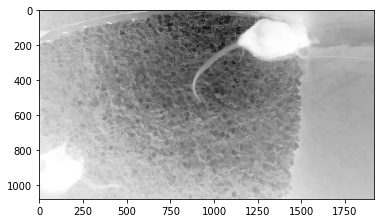

In [46]:
test_image = part_undistort_frames[1000]
just_mouse = test_image
plt.imshow(just_mouse, cmap="Greys")
plt.show()


The above image is a mouse. What is the fourier transform of an image with a partial mouse?

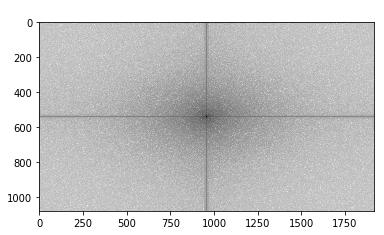

In [47]:
f = np.fft.fft2(just_mouse)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap='Greys')
plt.title("Fourier Transform of Mouse", color='white')
plt.show()

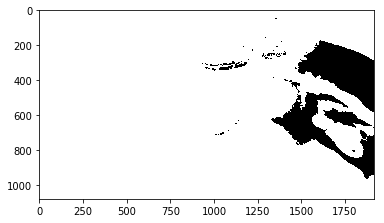

In [39]:
plt.imshow(background_sub[1200], cmap='Greys')
plt.show()

As the camera is an IR detector, maybe normal segmentation can be performed?

In [50]:
from skimage import filters
val = filters.threshold_otsu(just_mouse)
mask = just_mouse < val

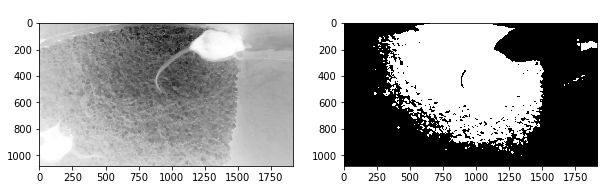

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(just_mouse, cmap='Greys')
ax[0].set_title('Original Image', color='white')
ax[1].imshow(mask, cmap='binary')
ax[1].set_title('Otsu Segmented Image', color='white')
plt.show()

Global threshold confuses the mice for the walls. Maybe a local threshold will work better?

In [90]:
just_mouse = part_undistort_frames[1000]

block_size = 501
local_thresh = skimage.filters.threshold_local(just_mouse, block_size, offset=10)
binary_local = just_mouse < local_thresh

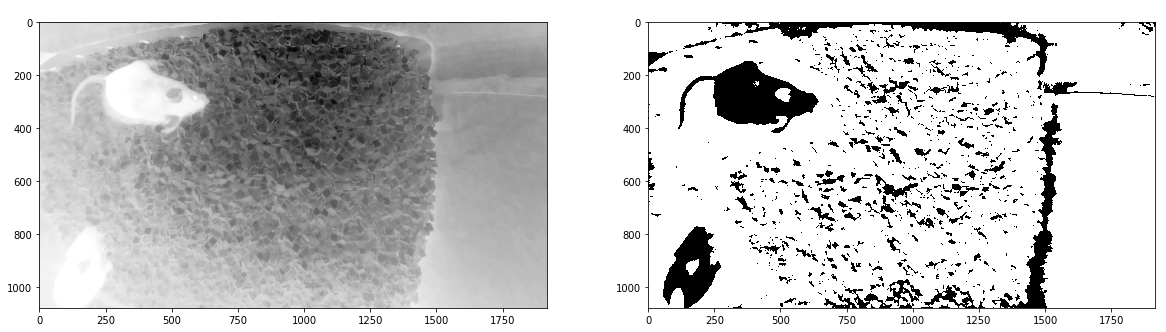

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(just_mouse, cmap='Greys')
ax[0].set_title('Original Image', color='white')
ax[1].imshow(binary_local, cmap='binary')
ax[1].set_title('Local Otsu Segmented Image', color='white')
plt.show()

This is a much better result. The image needs to be grouped by groups of pixels, threshold the group by area and morphology (what is the eccentricity of a mouse). From there the segmented images can multiplied by their normal image.

False


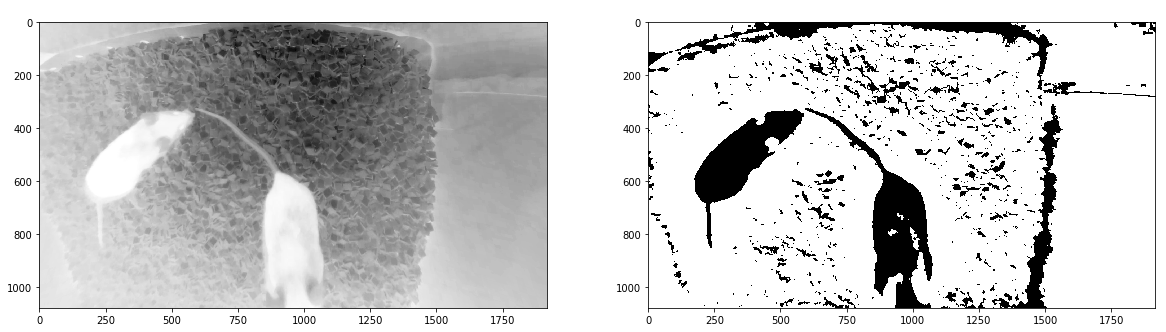

In [151]:
just_mouse = part_undistort_frames[600]
# Try on another image
block_size = 501
local_thresh = skimage.filters.threshold_local(just_mouse, block_size, offset=10)
binary_local = just_mouse < local_thresh
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(just_mouse, cmap='Greys')
ax[0].set_title('Original Image', color='white')
ax[1].imshow(binary_local, cmap='binary')
ax[1].set_title('Local Otsu Segmented Image', color='white')
print(binary_local[0,0])
plt.show()

In [154]:
image_labeled, number_labels = skimage.measure.label(binary_local, background=0, return_num=True)
# Get the properties of the labeled regions
image_props = skimage.measure.regionprops(image_labeled)

# Create a blank region of the original image
blank_background= np.zeros(binary_local.shape)

# Go through props
for index, prop in enumerate(image_props):
    #print(prop.area)
    # If the region properties are within the threshold
    if prop.area >= 1000 and prop.eccentricity <= 0.95:
        # Select the region
        #print(index)
        temp_seg = image_labeled==index+1
        filled_seg = temp_seg
        # Add the temp region
        blank_background = blank_background + filled_seg

# Fill the holes of the image
image_droplets = scipy.ndimage.binary_fill_holes(blank_background)

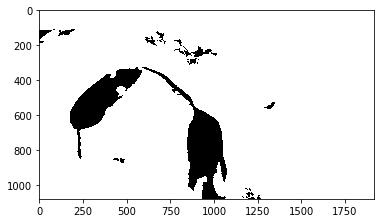

In [155]:
plt.imshow(image_droplets, cmap='Greys')
plt.show()

In [15]:
# Function to segment mice
def seg_mice(IR_image):
    """Use an IR image to segment mice using code from droplet class"""
    
    block_size = 1001
    
    
    local_thresh = skimage.filters.threshold_local(IR_image, block_size, offset=10)
    binary_local = IR_image < local_thresh
    
    image_labeled, number_labels = skimage.measure.label(binary_local, background=0, return_num=True)
    # Get the properties of the labeled regions
    image_props = skimage.measure.regionprops(image_labeled)

    # Create a blank region of the original image
    blank_background= np.zeros(binary_local.shape)

    # Go through props
    for index, prop in enumerate(image_props):
        #print(prop.area)
        # If the region properties are within the threshold
        if prop.area >= 20000 and prop.eccentricity <= 0.95:
            # Select the region
            #print(index)
            temp_seg = image_labeled==index+1
            filled_seg = temp_seg
            # Add the temp region
            blank_background = blank_background + filled_seg

    # Fill the holes of the image
    image_droplets = scipy.ndimage.binary_fill_holes(blank_background)
    image_droplets = image_droplets * 255
    
    return blank_background

In [18]:
#local_otsu_segment = []

import scipy.misc


for index, frame in enumerate(part_undistort_frames):
    if index % 10 == 0:
        print(index)
    new_frame = seg_mice(frame)
    name = '../../data/mouse_videos/thresh_video/thresh_' + str(index) + '.png'
    scipy.misc.imsave(name, new_frame)
    #local_otsu_segment.append(np.repeat(new_frame[:, :, np.newaxis], 3, axis=2))
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430


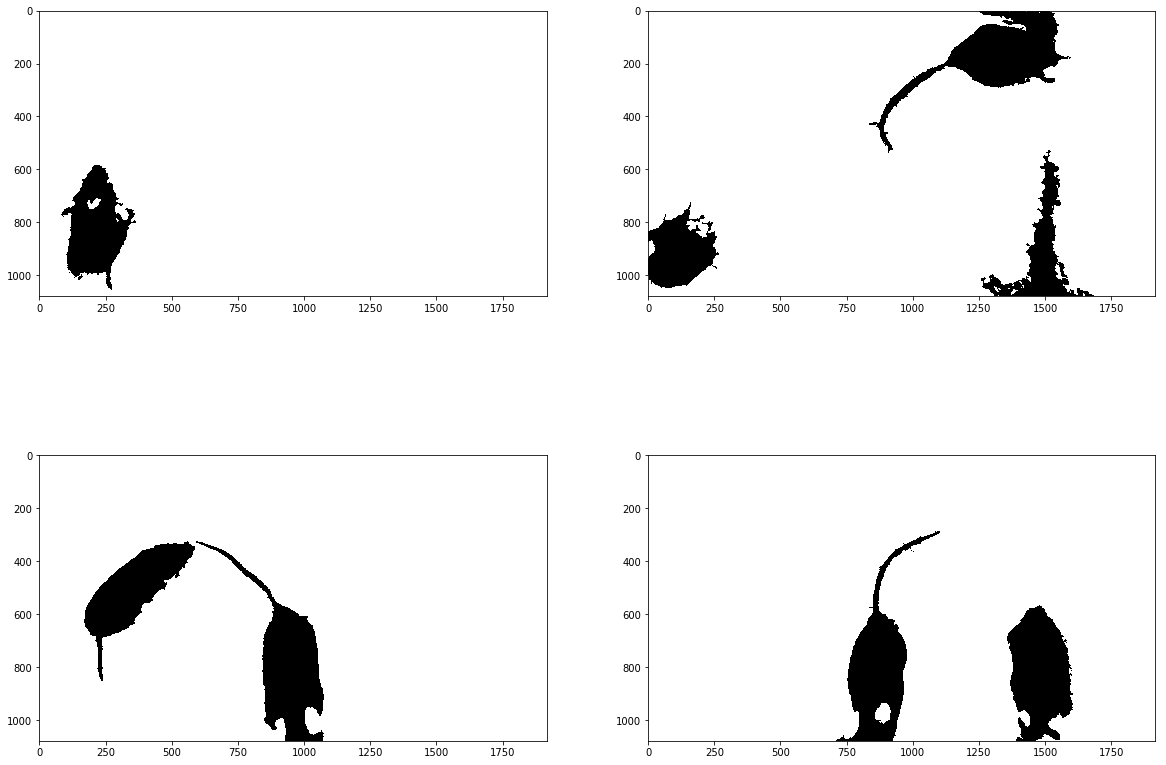

In [260]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0, 0].imshow(seg_mice(part_undistort_frames[200]), cmap='Greys')
ax[0, 1].imshow(seg_mice(part_undistort_frames[1001]), cmap='Greys')
ax[1, 0].imshow(seg_mice(part_undistort_frames[600]), cmap='Greys')
ax[1, 1].imshow(seg_mice(part_undistort_frames[1300]), cmap='Greys')
plt.show()

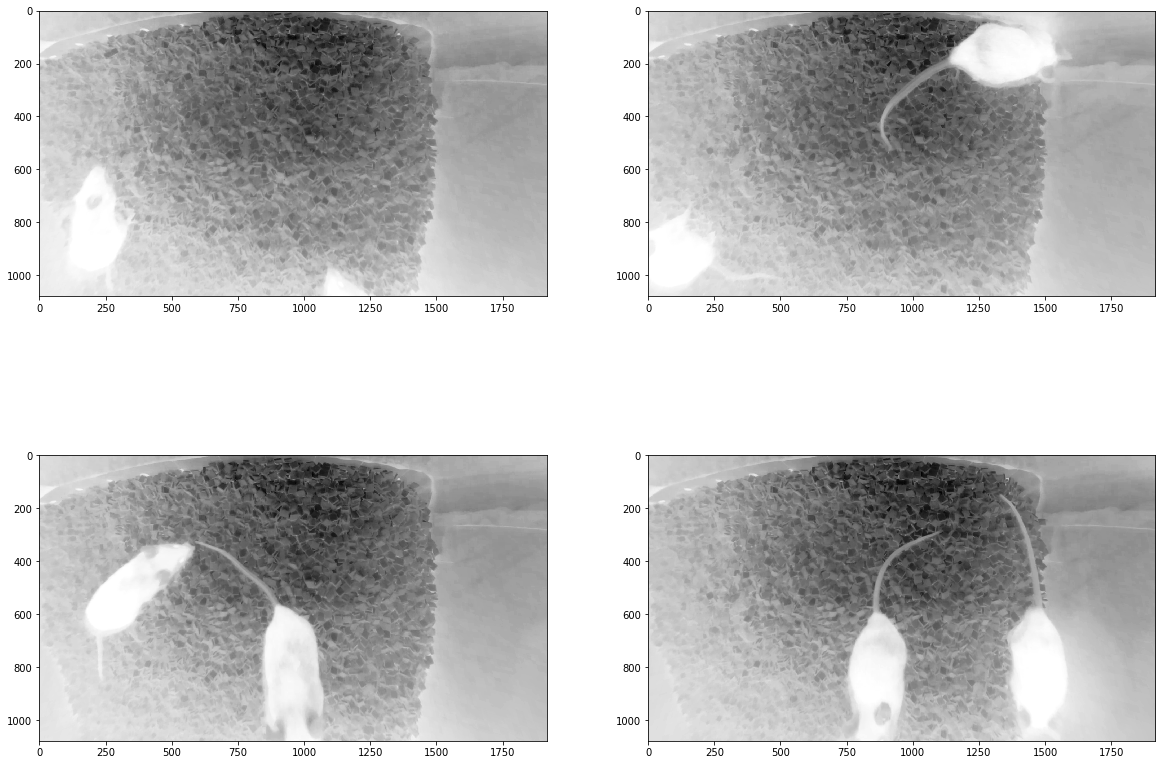

In [271]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0, 0].imshow((part_undistort_frames[200]), cmap='Greys')
ax[0, 1].imshow((part_undistort_frames[1001]), cmap='Greys')
ax[1, 0].imshow((part_undistort_frames[600]), cmap='Greys')
ax[1, 1].imshow((part_undistort_frames[1300]), cmap='Greys')
plt.show()

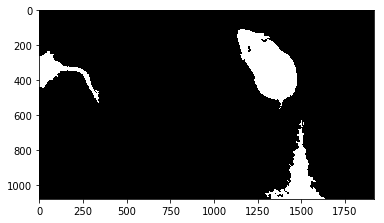

In [275]:
plt.imshow(local_otsu_segment[50])
plt.show()

In [270]:
skvideo.io.vwrite('../../data/mouse_videos/threshthresh_test.m4v', local_otsu_segment[:])

In [283]:
import scipy.misc
for index, frame in enumerate(local_otsu_segment):
    name = '../../data/mouse_videos/thresh_video/thresh_' + str(index) + '.png'
    scipy.misc.imsave(name, frame)
